In [1]:
import sys
import os

package_path = ".."
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import h5py
import hdf5plugin


from CordaX.config import load_config, ExpConfig

In [99]:
def get_hdf5_images(file: str, config: ExpConfig) -> npt.NDArray:
    """get images form hdf5"""
    with h5py.File(file, "r") as hf:
        if "detector" not in hf:
            raise KeyError(f"Key 'detector' not found in {file}")

        images = np.asarray(
            hf[
                f"detector/{config.param.hutch.value}/{config.param.detector.value}/image/block0_values"
            ]
        )

        return images  # np.maximum(images, 0)

In [100]:
from CordaX.filesystem import get_run_scan_directory

config = load_config(reload=True)
file = get_run_scan_directory(config.path.load_dir, 18, 1, 53)
print(file)
arr = get_hdf5_images(file, config)

/xfel/ffs/dat/ue_250324_FXS/raw_data/h5/type=raw/run=018/scan=001/p0053.h5


In [101]:
np.shape(arr)

(600, 514, 1030)

In [6]:
indbad = np.where(arr < 0)

In [7]:
indlist = []
listmin = []

for ii in range(np.shape(arr)[0]):
    indlist.append(np.where(arr[ii, :, :] < -17500))

    listmin.append(arr[ii, :, :].min())

In [32]:
one_zeros = np.where(arr < -10000, 1, 0)
mask = np.nansum(one_zeros, 0)
mask[mask == 0] = 1
mask[mask == np.float32(np.shape(arr)[0])] = 0

In [34]:
masked_arr = arr * mask
masked_arr_sum = np.nansum(masked_arr, 0)

In [36]:
np.where(masked_arr_sum < 500)

(array([  0,   0,   0, ..., 513, 513, 513], shape=(529250,)),
 array([   0,    1,    2, ..., 1027, 1028, 1029], shape=(529250,)))

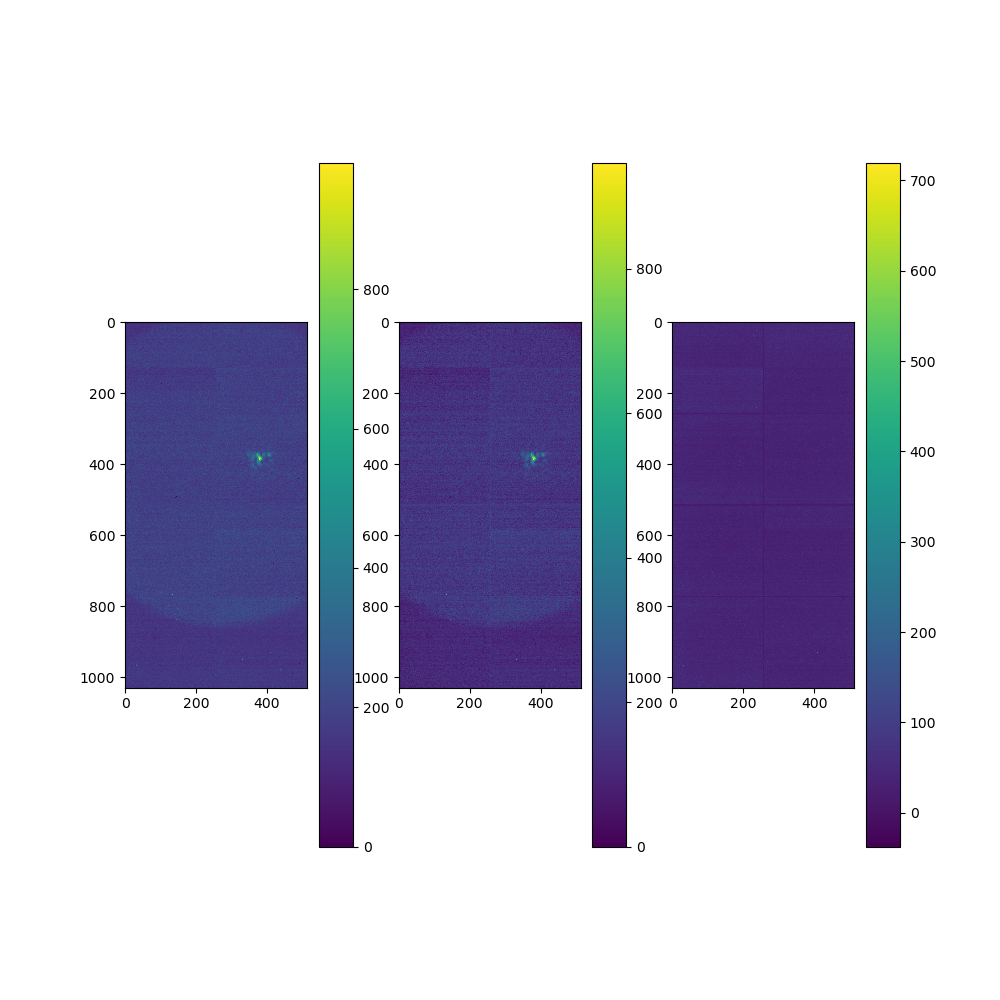

In [59]:
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(131)
arr[arr < 0] = 0
to_plot = np.nansum(arr, 0)
to_plot[11, 25] = 0
to_plot = np.transpose(to_plot)
img1 = ax.imshow(to_plot, interpolation="none")
plt.colorbar(img1)

ax2 = fig1.add_subplot(132)
masked_arr_sum[masked_arr_sum < 0] = 0
img2 = ax2.imshow(np.transpose(masked_arr_sum), interpolation="none")
plt.colorbar(img2)


ax3 = fig1.add_subplot(133)
img3 = ax3.imshow(to_plot - np.transpose(masked_arr_sum), interpolation="none")
plt.colorbar(img3)

In [95]:
def h5_tree(val, pre="", out=""):
    length = len(val)
    for key, val in val.items():
        length -= 1
        if length == 0:  # the last item
            if type(val) == h5py._hl.group.Group:
                out += pre + "└── " + key + "\n"
                out = h5_tree(val, pre + "    ", out)
            else:
                out += pre + "└── " + key + f" {val.shape}\n"
        else:
            if type(val) == h5py._hl.group.Group:
                out += pre + "├── " + key + "\n"
                out = h5_tree(val, pre + "│   ", out)
            else:
                out += pre + "├── " + key + f" {val.shape}\n"
    return out


testh5 = config.path.load_dir + "run=018/scan=001/p0053.h5"
filename = testh5
with h5py.File(filename, "r") as file:
    structure = h5_tree(file)
    print(structure)

├── detector
│   └── eh1
│       └── jungfrau2
│           └── image
│               ├── axis1 (600,)
│               ├── block0_items (600,)
│               └── block0_values (600, 514, 1030)
├── metadata
│   ├── axis0 (196,)
│   ├── axis1 (600,)
│   ├── block0_items (30,)
│   ├── block0_values (600, 30)
│   ├── block1_items (70,)
│   ├── block1_values (600, 70)
│   ├── block2_items (43,)
│   ├── block2_values (600, 43)
│   ├── block3_items (53,)
│   └── block3_values (1,)
└── qbpm
    ├── eh1
    │   └── qbpm1
    │       ├── waveforms.ch1
    │       │   ├── axis0 (50000,)
    │       │   ├── axis1 (600,)
    │       │   ├── block0_items (50000,)
    │       │   └── block0_values (600, 50000)
    │       ├── waveforms.ch2
    │       │   ├── axis0 (50000,)
    │       │   ├── axis1 (600,)
    │       │   ├── block0_items (50000,)
    │       │   └── block0_values (600, 50000)
    │       ├── waveforms.ch3
    │       │   ├── axis0 (50000,)
    │       │   ├── axis1 (600,)
    │     

In [96]:
filename = testh5

with h5py.File(filename, "r") as f:
    detimage = f["/detector/eh1/jungfrau2/image/block0_values"][:, :, :]

In [92]:
import tifffile

fn_save = (
    "/home/hxpp-admin/Desktop/sogang/250324_sogang/analysis/test_DS1/img1200_18_53.tif"
)
tifffile.imwrite(fn_save, detimage)

/tmp/ipykernel_14235/2637840111.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure(figsize=(10,10))


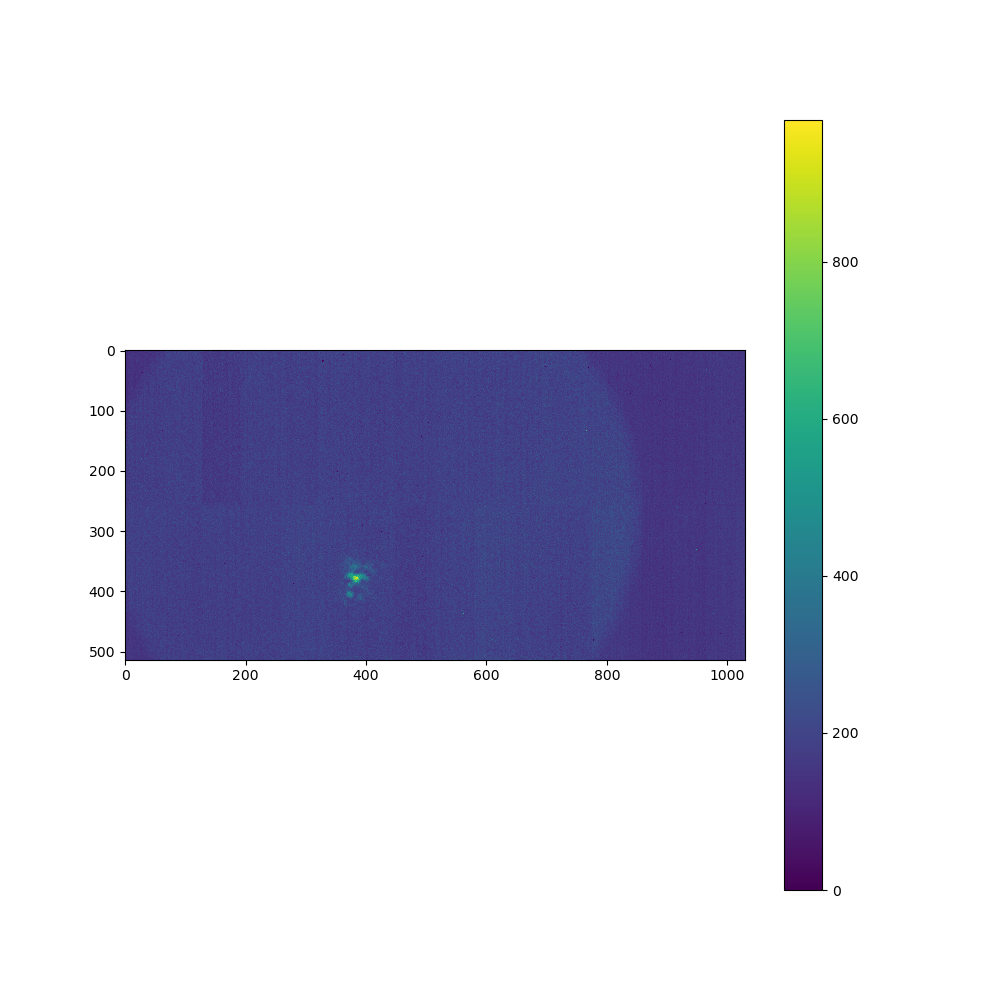

In [97]:
np.shape(detimage)

fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(111)
detimage[detimage < 0] = 0
to_plot = np.nansum(detimage[:, :, :], 0)
to_plot[to_plot > 1600] = 0
to_plot[11, 25] = 0
to_plot = to_plot
img1 = ax.imshow(to_plot, interpolation="none")
plt.colorbar(img1)

In [79]:
filename = testh5

with h5py.File(filename, "r") as f:
    block0_items = list(f["/metadata/block0_items"])
    block1_items = list(f["/metadata/block1_items"])
    block2_items = list(f["/metadata/block2_items"])
    block3_items = list(f["/metadata/block3_items"])
    block0_values = list(f["/metadata/block0_values"])

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys)
    # these can be group or dataset names
    print("Keys: %s" % f["/metadata/"].keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key]))

    # If a_group_key is a group name,
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name,
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # # preferred methods to get dataset values:
    # ds_obj = f[a_group_key]      # returns as a h5py dataset object
    # ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values', 'block3_items', 'block3_values']>
<class 'h5py._hl.group.Group'>


In [85]:
def print_list(ll):
    for ii in range(len(ll)):
        print(f"{ii: } {ll[ii]}")


print("block 0")
print_list(block0_items)
print("block 1")
print_list(block1_items)
print("block 2")
print_list(block2_items)
print("block 3")
print_list(block3_items)

block 0
 0 b'detector_eh1_jungfrau2_calibrated'
 1 b'detector_eh1_jungfrau2_dark_bkg_substrated'
 2 b'timestamp_info.BL_DETECTOR'
 3 b'timestamp_info.BL_DETECTORX2'
 4 b'timestamp_info.FIFTEEN_HERTZ'
 5 b'timestamp_info.FIVE_HERTZ'
 6 b'timestamp_info.RATE_HX_10HZ'
 7 b'timestamp_info.RATE_HX_15HZ'
 8 b'timestamp_info.RATE_HX_1HZ'
 9 b'timestamp_info.RATE_HX_20HZ'
 10 b'timestamp_info.RATE_HX_2HZ'
 11 b'timestamp_info.RATE_HX_30HZ'
 12 b'timestamp_info.RATE_HX_5HZ'
 13 b'timestamp_info.RATE_HX_60HZ'
 14 b'timestamp_info.RATE_HX_HALFHZ'
 15 b'timestamp_info.RATE_SX_10HZ'
 16 b'timestamp_info.RATE_SX_15HZ'
 17 b'timestamp_info.RATE_SX_1HZ'
 18 b'timestamp_info.RATE_SX_20HZ'
 19 b'timestamp_info.RATE_SX_2HZ'
 20 b'timestamp_info.RATE_SX_30HZ'
 21 b'timestamp_info.RATE_SX_5HZ'
 22 b'timestamp_info.RATE_SX_HALFHZ'
 23 b'timestamp_info.SIXTY_HERTZ'
 24 b'timestamp_info.TEN_HERTZ'
 25 b'timestamp_info.THIRTY_HERTZ'
 26 b'timestamp_info.TWENTY_HERTZ'
 27 b'timestamp_info.XFEL_BEAM'
 28 b'times

In [53]:
print(np.where(to_plot == to_plot.max()))
print(np.where(masked_arr_sum == masked_arr_sum.max()))

(array([377]), array([386]))
(array([377]), array([386]))


In [46]:
np.ravel_multi_index([np.argmax(np.nansum(arr, 0))], arr.shape[1:])

ValueError: parameter multi_index must be a sequence of length 2

In [27]:
test = set(np.reshape(one_zeros_sum, -1))
test

{np.int64(0), np.int64(600)}

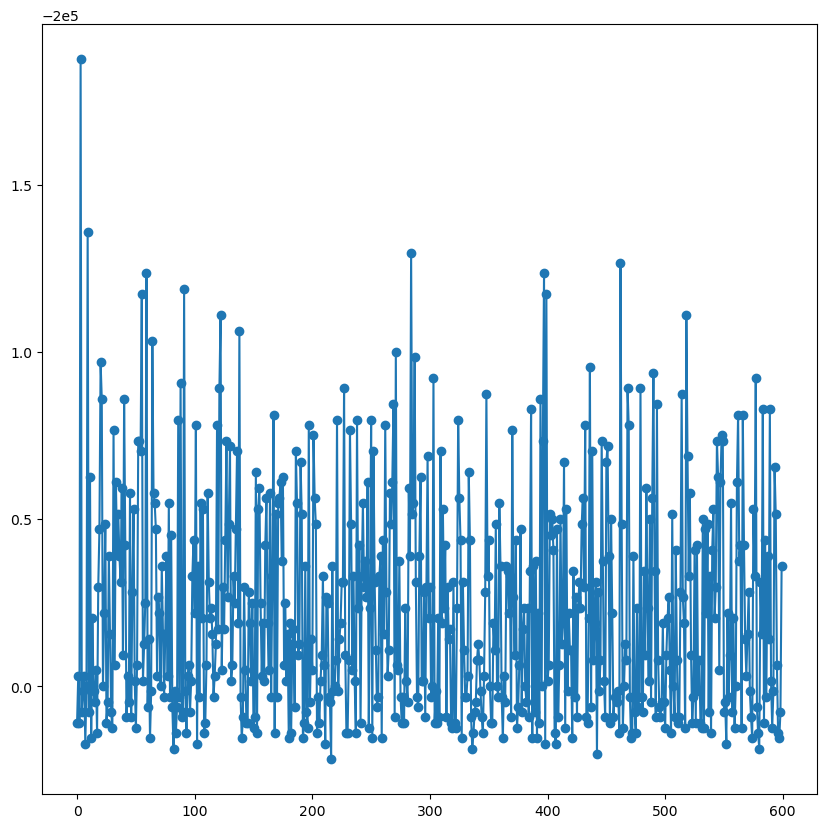

In [10]:
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(111)
ax.plot(listmin, "-o")

In [45]:
indlist[0][1][0:]

array([   2,    4,    6, ..., 1022, 1024, 1029])

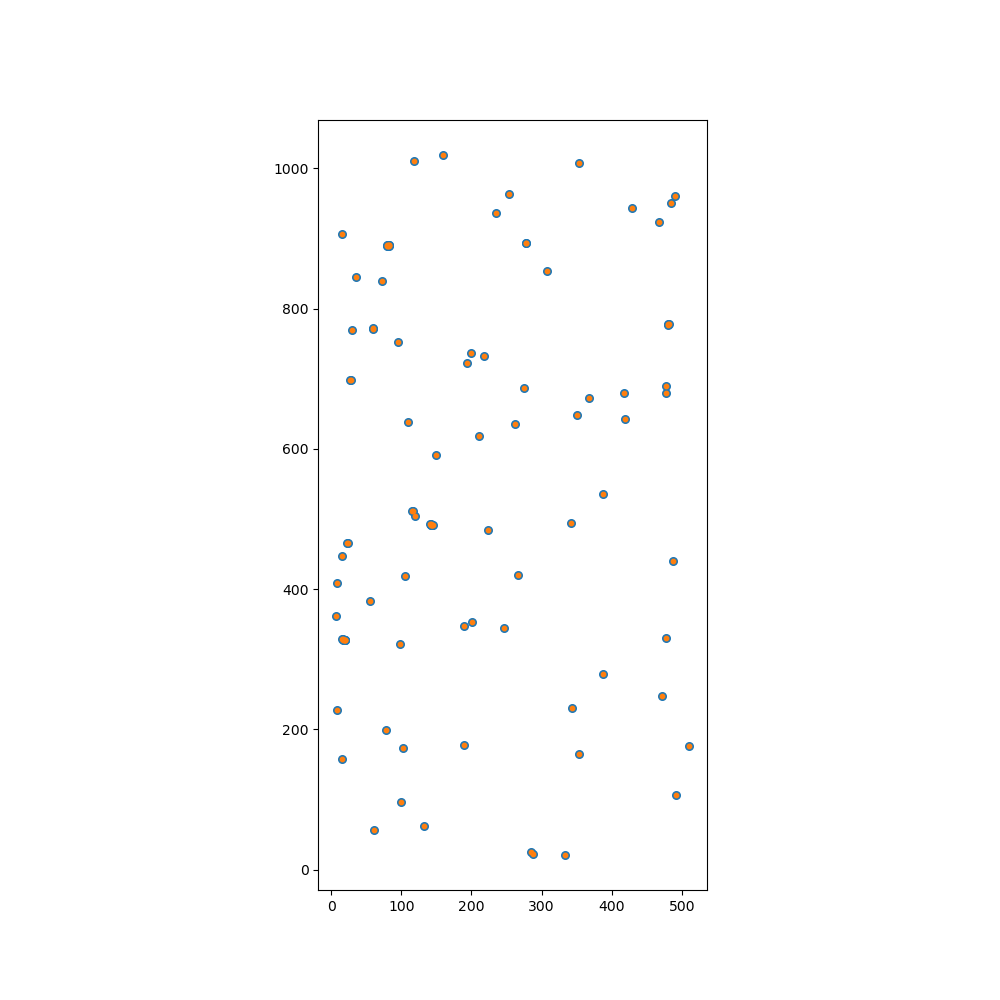

In [12]:
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(111)
ax.scatter(indlist[0][0], indlist[0][1], 30)
ax.scatter(indlist[400][0], indlist[400][1], 10)
ax.set_aspect(1)
# ax.plot(indlist[100][0], '-o')0

In [9]:
%matplotlib widget

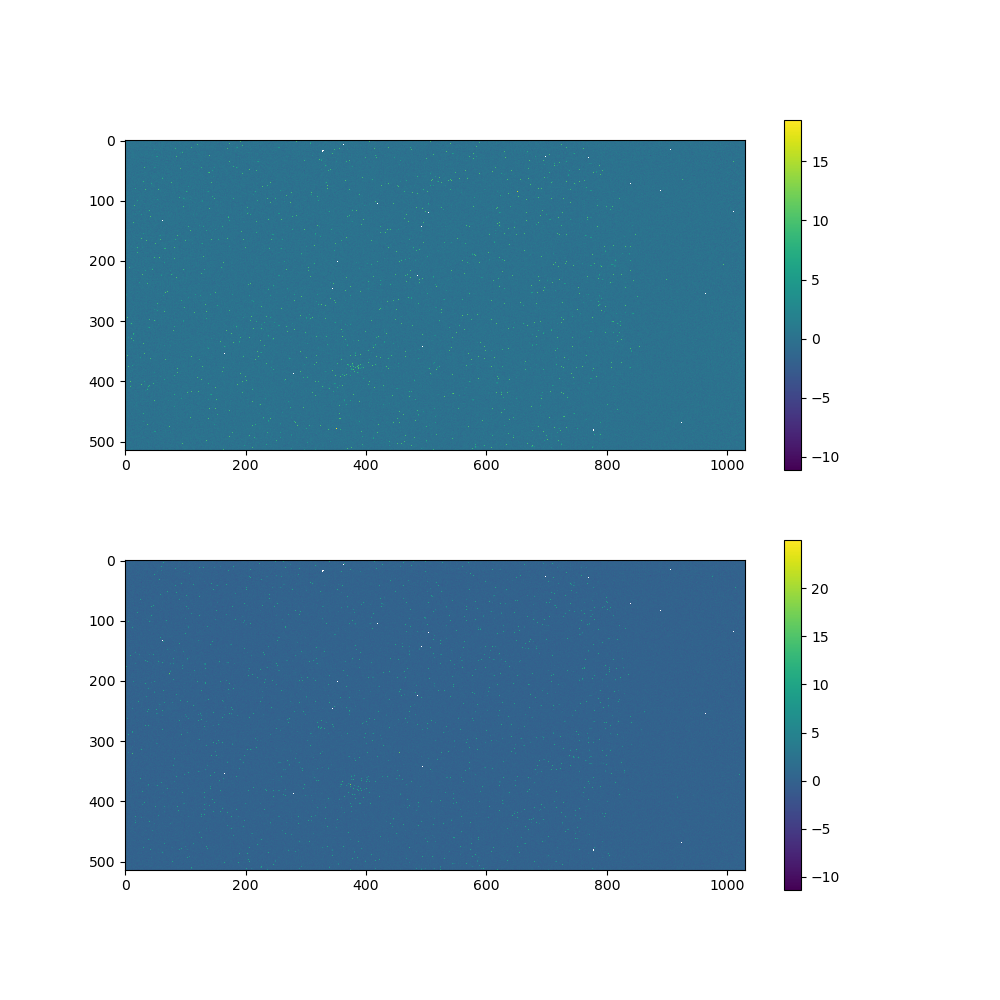

In [102]:
fig1 = plt.figure(figsize=(10, 10))

mask = np.ones((np.shape(arr)[1], np.shape(arr)[2]))
mask[:, :] = arr[0, :, :]
mask[mask < -17500] = np.nan
mask[~np.isnan(mask)] = 1


ax = fig1.add_subplot(211)
img1 = ax.imshow(arr[0, :, :] * mask, interpolation="none")
plt.colorbar(img1)


ax = fig1.add_subplot(212)

img1 = ax.imshow(arr[100, :, :] * mask, interpolation="none")
plt.colorbar(img1)

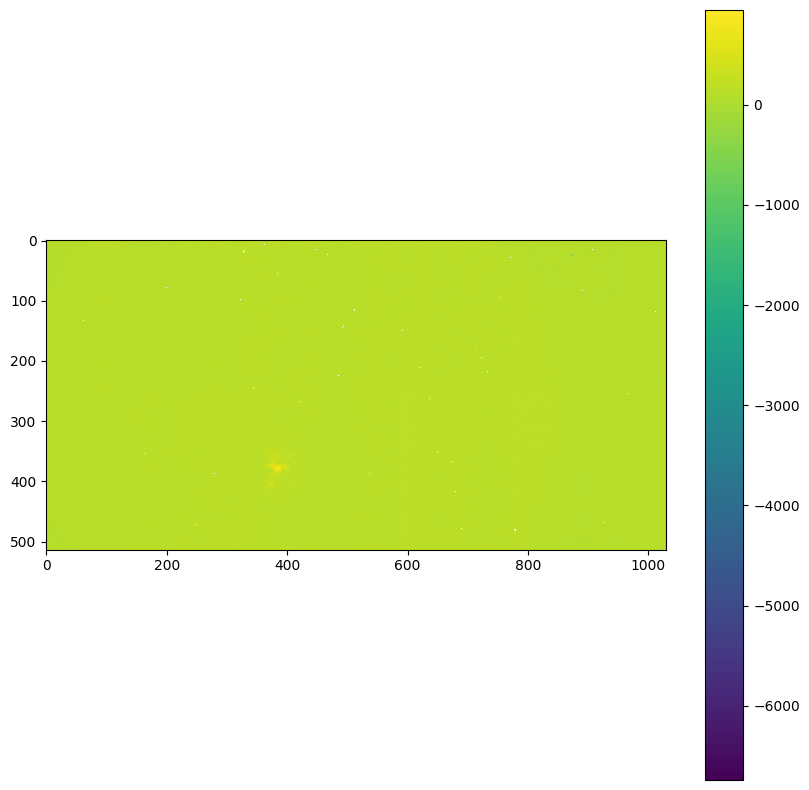

In [34]:
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(111)
img1 = ax.imshow(np.nansum(arr, 0) * mask, interpolation="none")
plt.colorbar(img1)

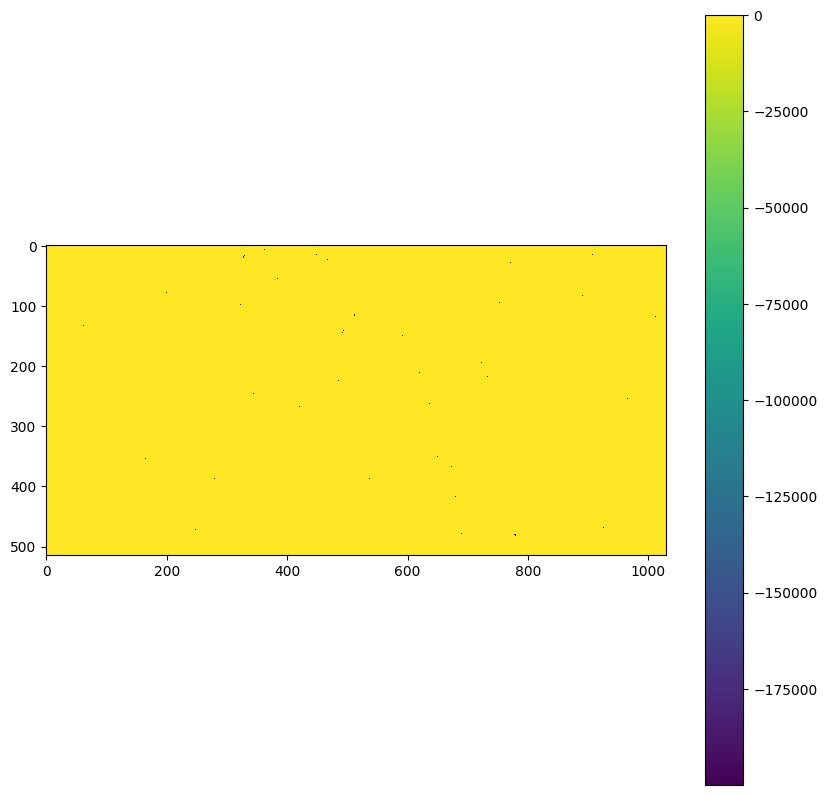

In [28]:
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(111)
img1 = ax.imshow(arr[100, :, :], interpolation="none")
plt.colorbar(img1)